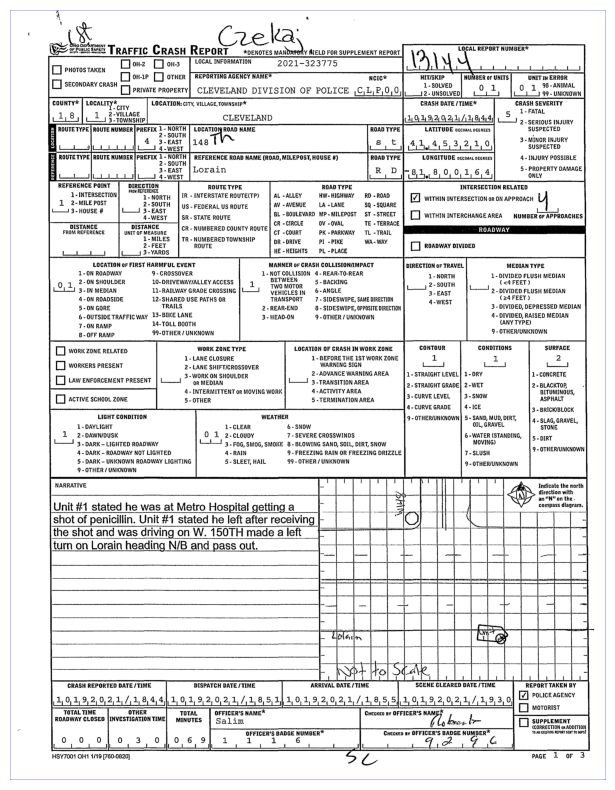

Processing ../data/raw/oh1_pdf_files/202100323775/page_1.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


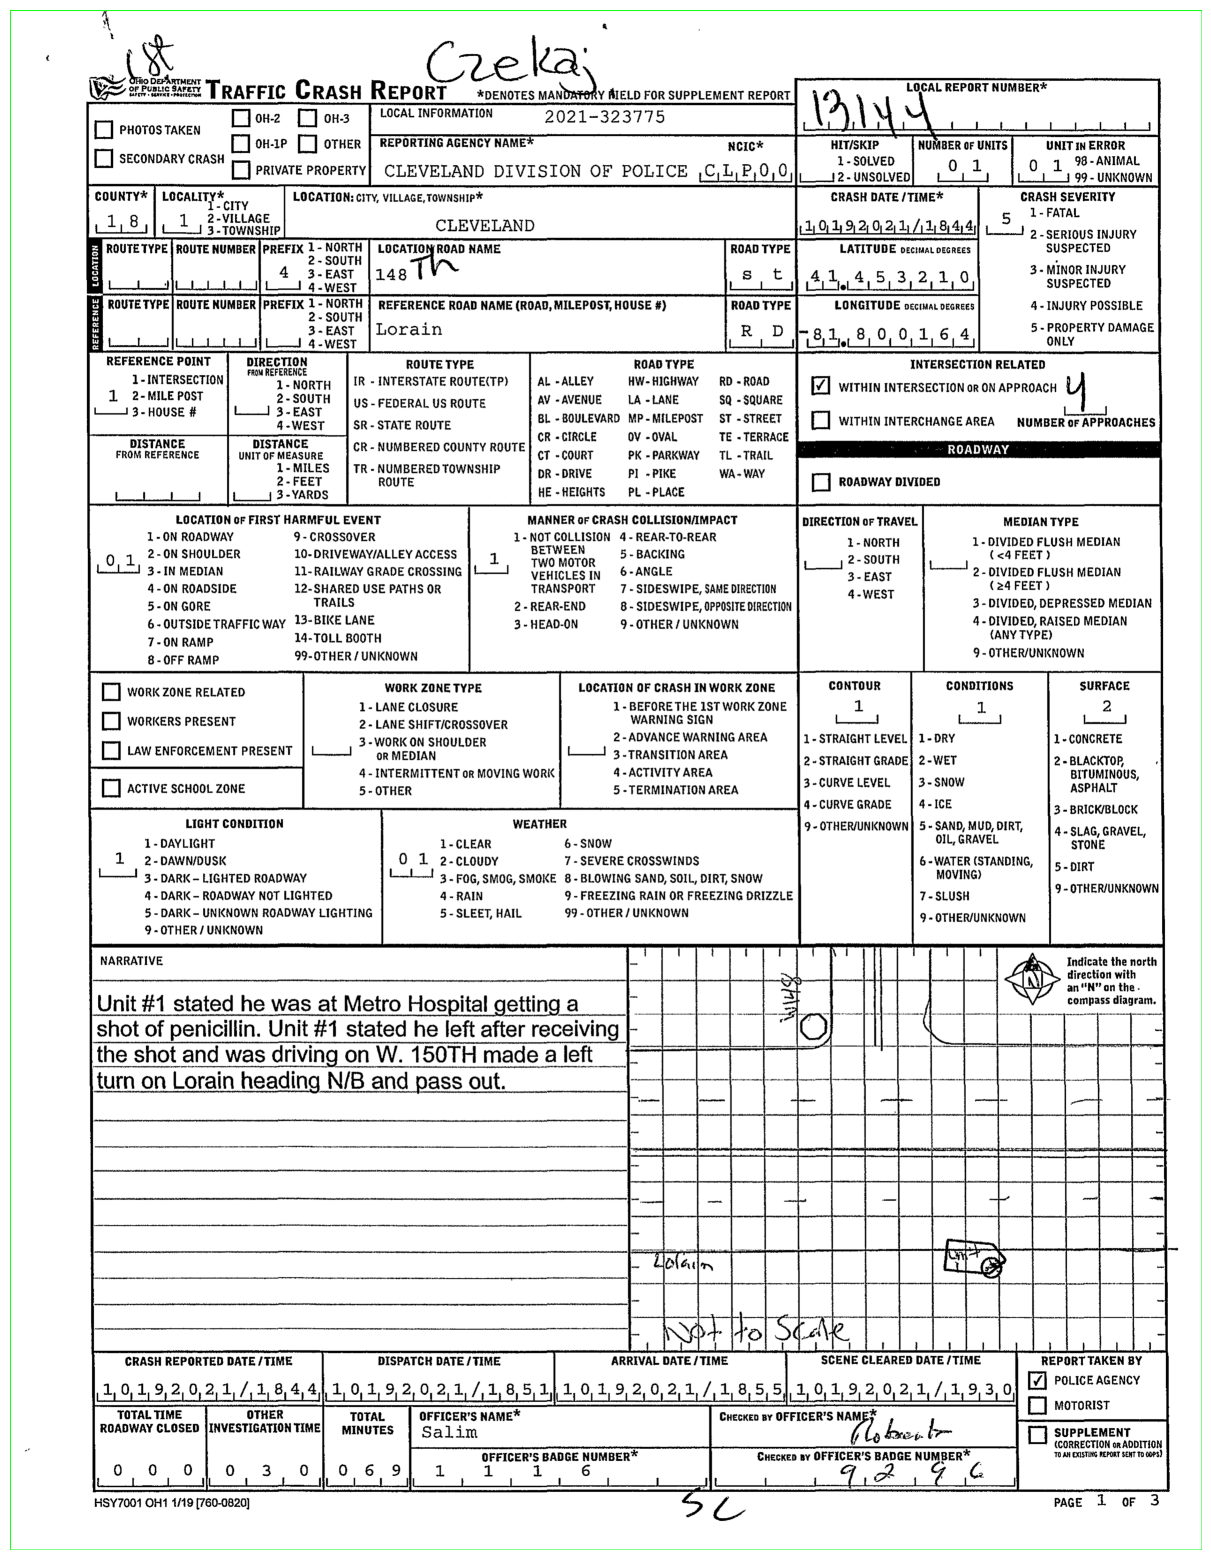

Processing ../data/raw/oh1_pdf_files/202100323775/page_2.png
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


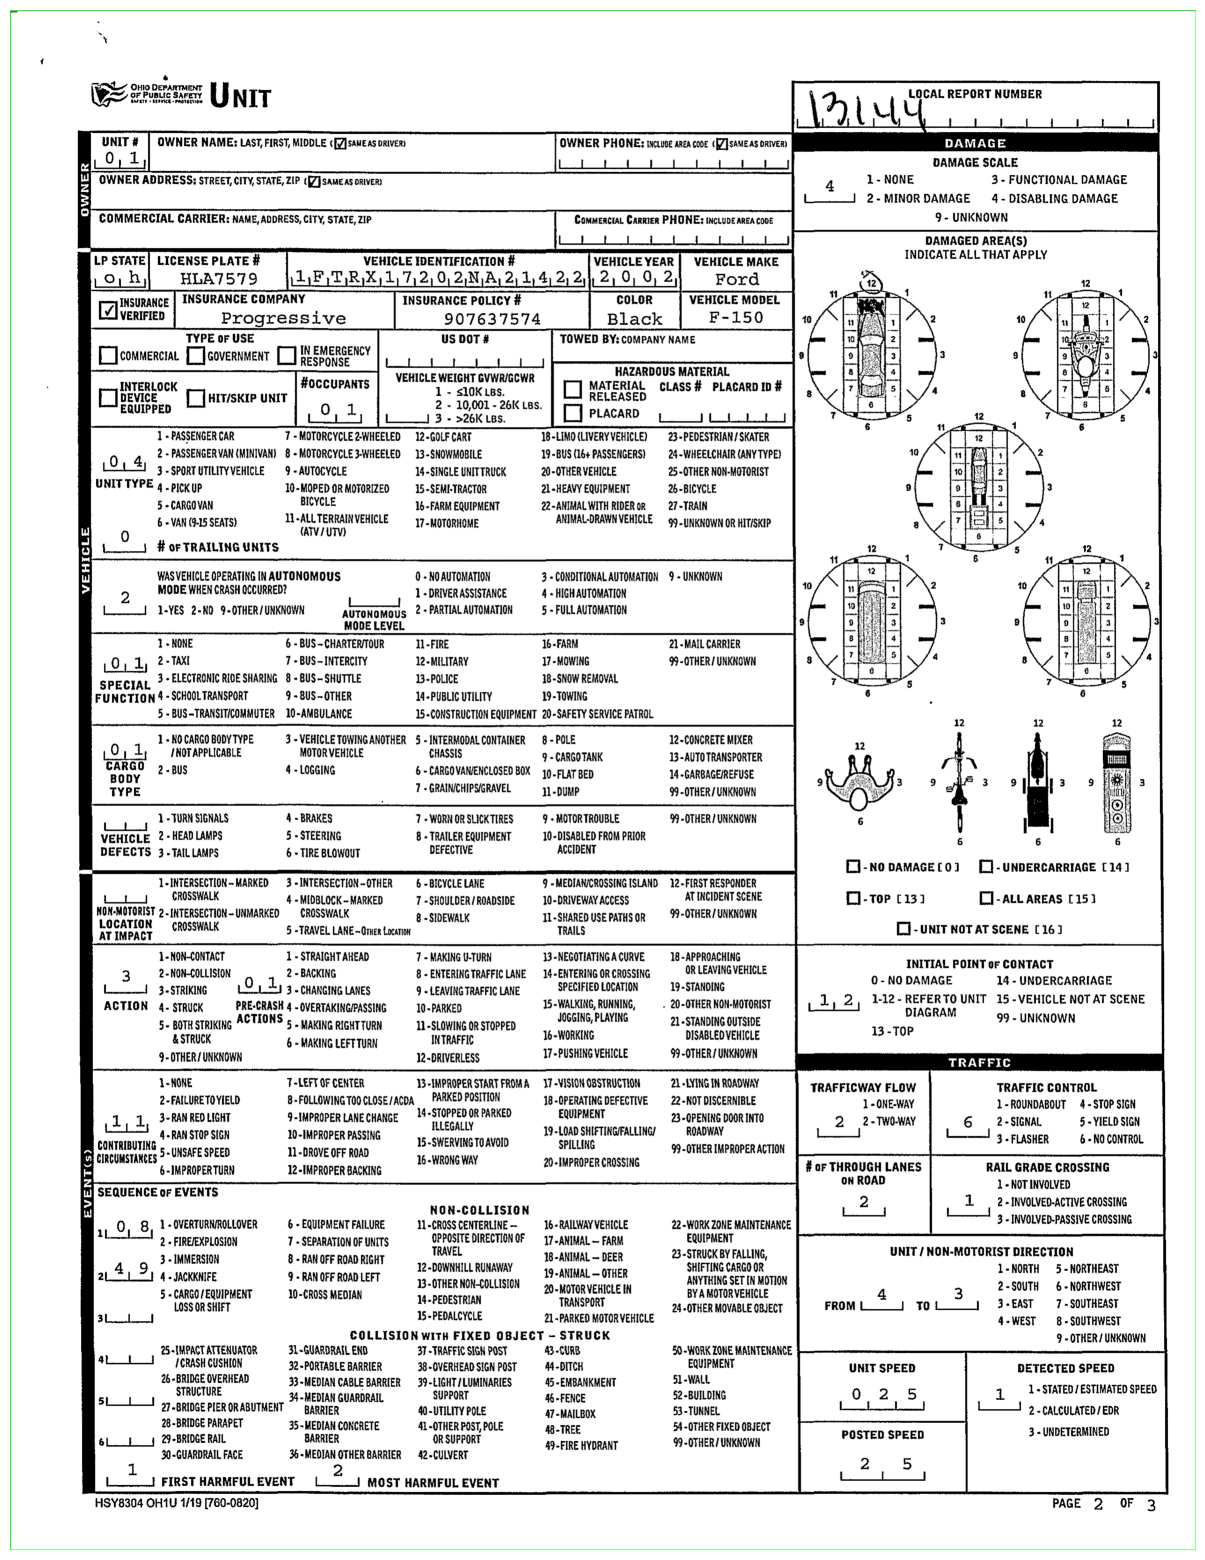

Processing ../data/raw/oh1_pdf_files/202100323775/page_3.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


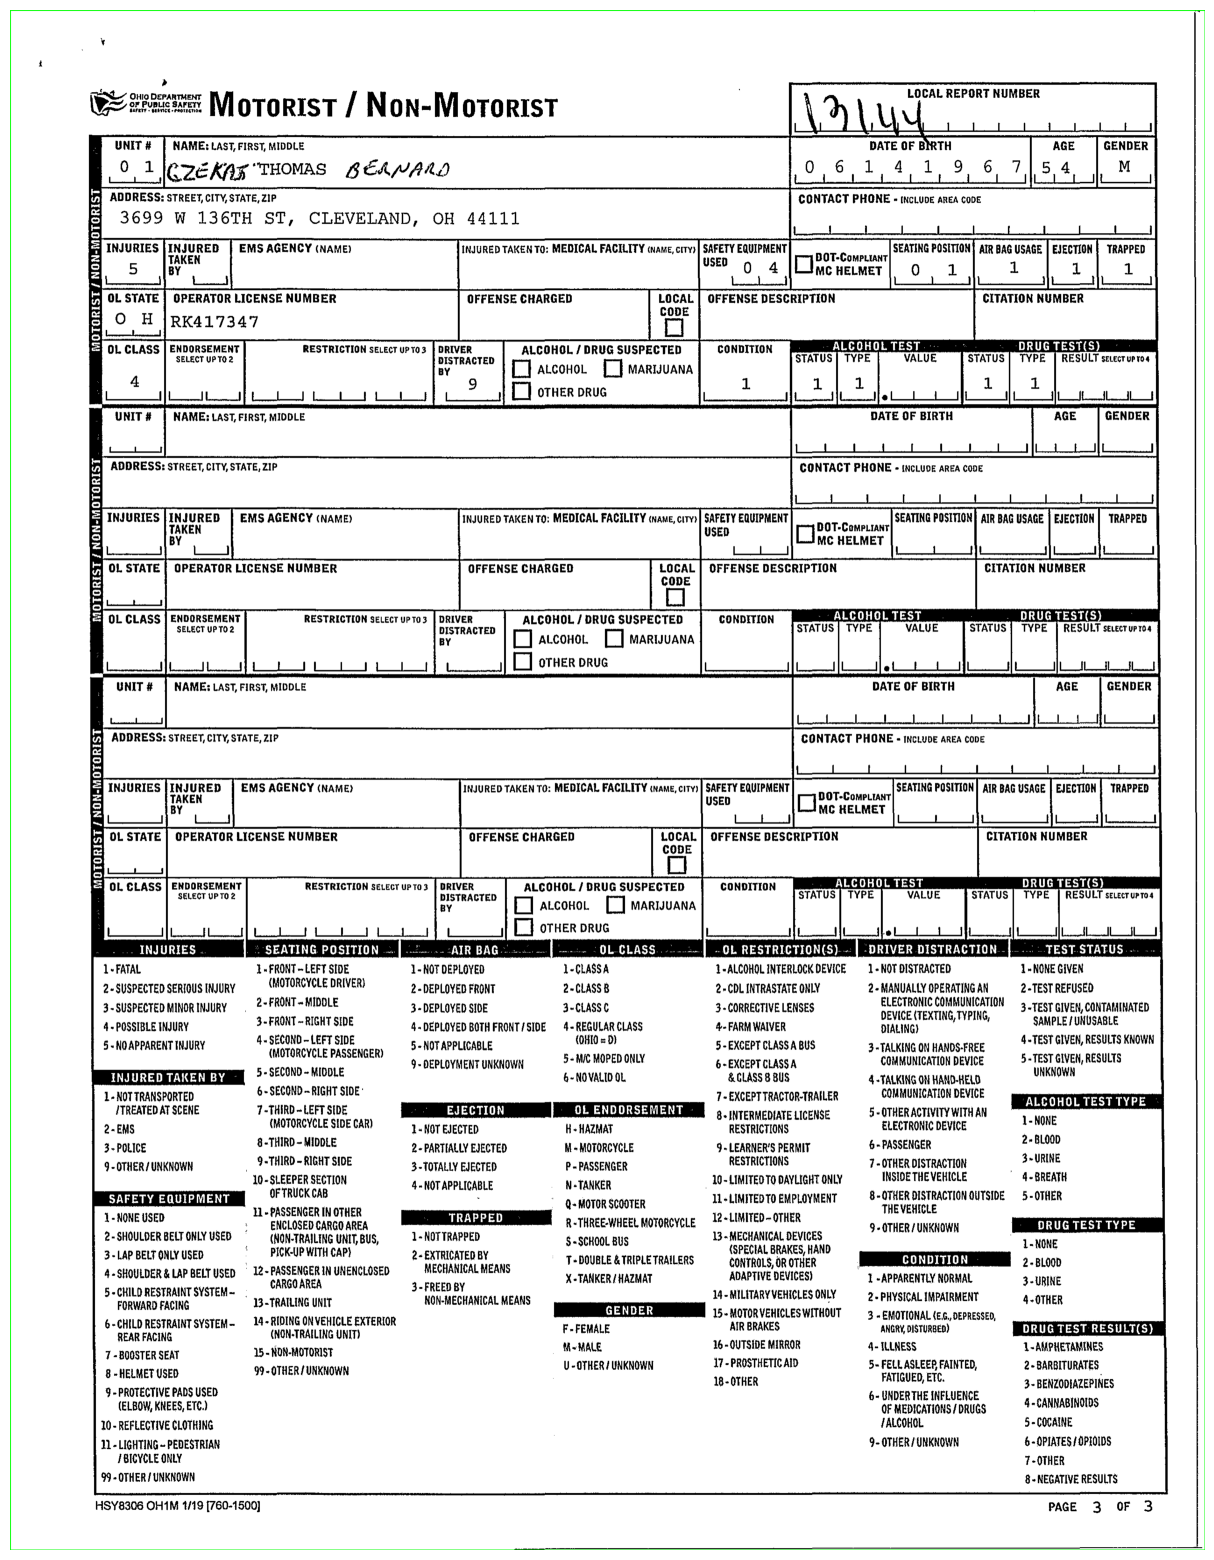

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path


# Function to convert PDF to images (PNG format)
def convert_pdf_to_images(pdf_path, output_folder, dpi=300):
    # Convert PDF pages to images
    images = convert_from_path(pdf_path, dpi=dpi)

    image_files = []
    for i, image in enumerate(images):
        # Save each page as a PNG file
        image_path = os.path.join(output_folder, f"page_{i + 1}.png")
        image.save(image_path, "PNG")
        image_files.append(image_path)

    return image_files


# Function to detect lines and draw boxes on the images
def detect_lines_and_draw_boxes(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection (Canny Edge Detector)
    edges = cv2.Canny(gray, 100, 200, apertureSize=3)
    print(edges)

    # Detect horizontal and vertical lines using morphological operations
    horizontal_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (40, 1)
    )  # Horizontal kernel
    vertical_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (1, 40)
    )  # Vertical kernel

    # Detect horizontal lines
    horizontal_lines = cv2.morphologyEx(
        edges, cv2.MORPH_OPEN, horizontal_kernel, iterations=5
    )

    # Detect vertical lines
    vertical_lines = cv2.morphologyEx(
        edges, cv2.MORPH_OPEN, vertical_kernel, iterations=5
    )

    # Combine both horizontal and vertical lines
    combined_lines = cv2.addWeighted(horizontal_lines, 1, vertical_lines, 1, 0)

    # Invert the image (to use contours)
    combined_lines_inv = cv2.bitwise_not(combined_lines)

    # Find contours
    contours, _ = cv2.findContours(
        combined_lines_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Draw bounding boxes around detected fields
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if (
            w > 3 and h > 3
        ):  # Set a minimum width and height to avoid small artifacts
            cv2.rectangle(
                image, (x, y), (x + w, y + h), (0, 255, 0), 2
            )  # Draw green boxes

    # Show the result with the bounding boxes
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


# Main function to process PDF files
def process_pdf_file(pdf_path, output_folder):
    # Convert PDF to images
    image_files = convert_pdf_to_images(pdf_path, output_folder)

    # Process each PNG image for line detection
    for image_file in image_files:
        print(f"Processing {image_file}")
        detect_lines_and_draw_boxes(image_file)


# Example usage:
pdf_file_path = (
    "../data/raw/oh1_pdf_files/202100323775.pdf"  # Path to your PDF file
)
output_folder = (
    "../data/raw/oh1_pdf_files/202100323775"  # Folder to store images
)
os.makedirs(output_folder, exist_ok=True)

# Process the PDF file
process_pdf_file(pdf_file_path, output_folder)

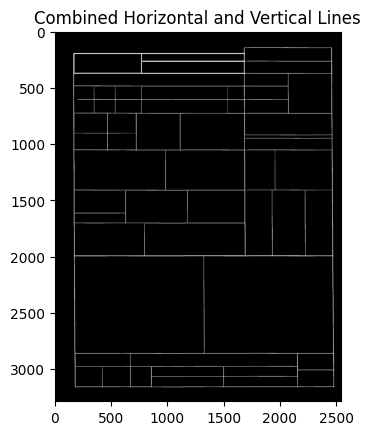

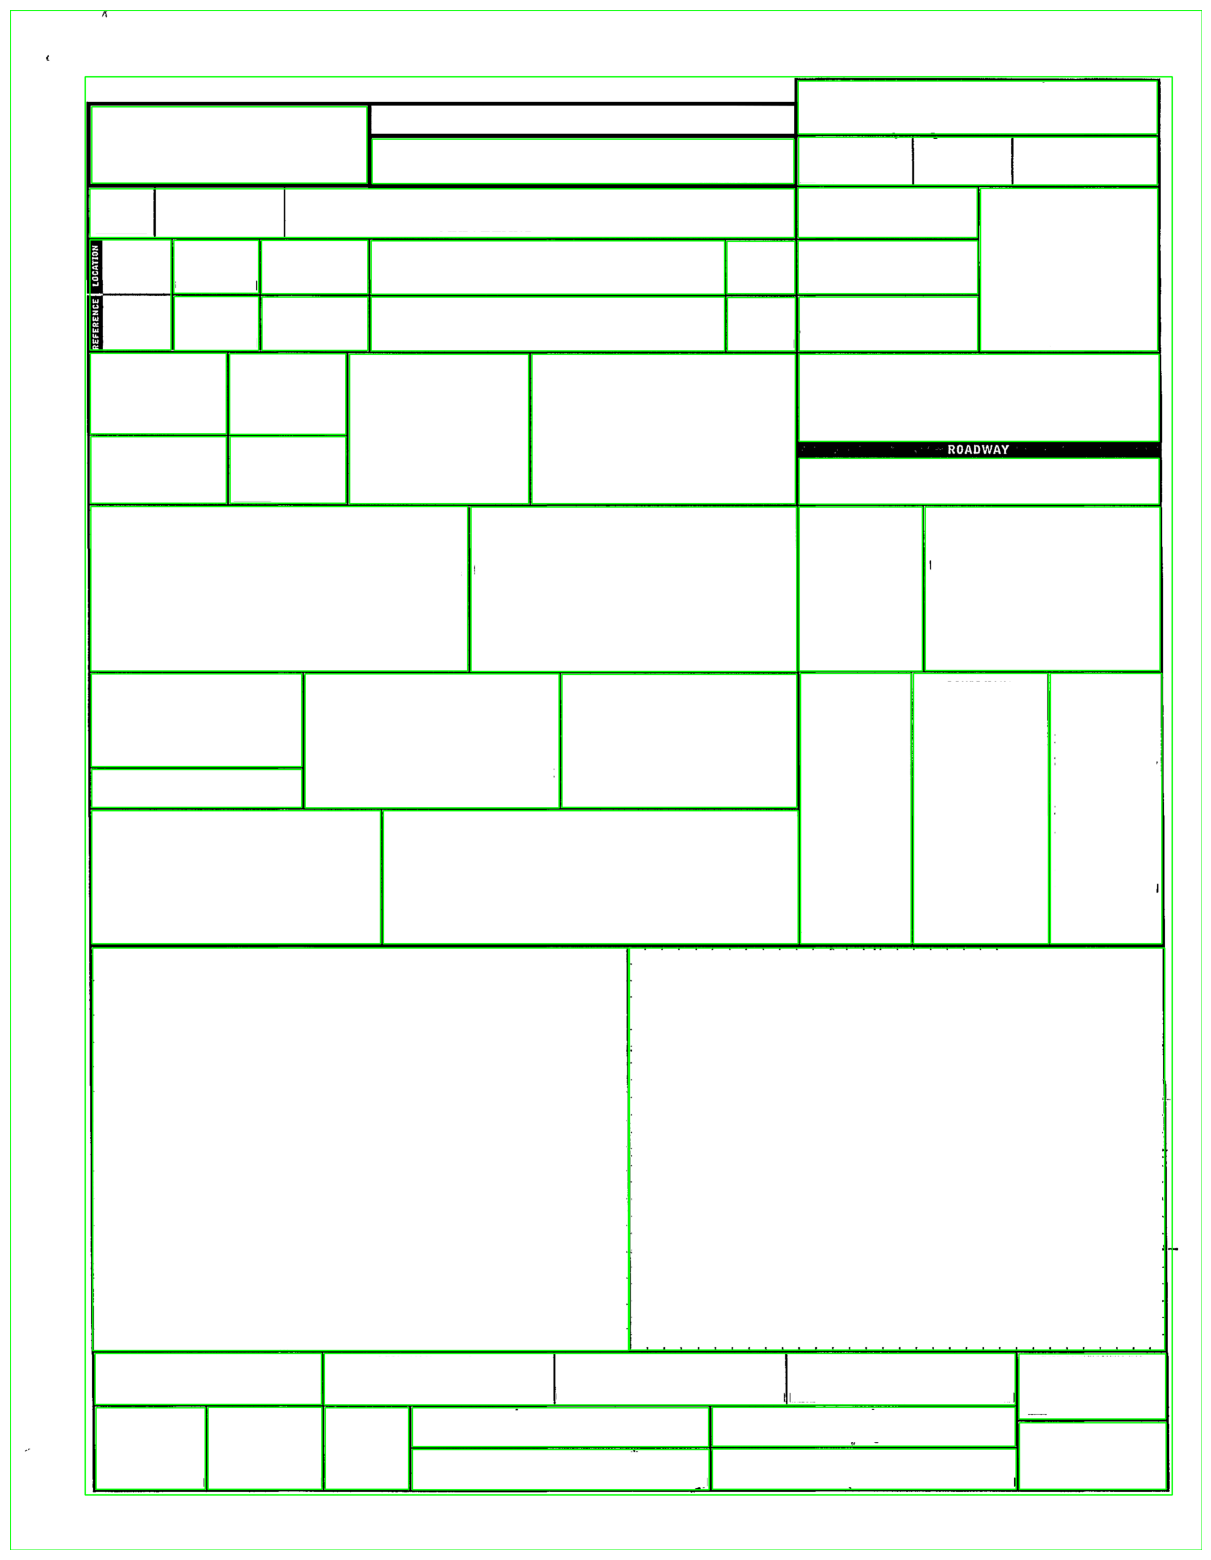

In [133]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pytesseract
import re


def detect_boxes_from_lines(image_path, output_folder):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 50
    )
    horizontal_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (80, 1)
    )  # Larger horizontal kernel
    vertical_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (1, 80)
    )  # Larger vertical kernel
    horizontal_lines = cv2.morphologyEx(
        thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2
    )
    vertical_lines = cv2.morphologyEx(
        thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2
    )
    combined_lines = cv2.addWeighted(horizontal_lines, 1, vertical_lines, 1, 0)
    plt.title("Combined Horizontal and Vertical Lines")
    plt.imshow(combined_lines, cmap="gray")
    plt.show()
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(combined_lines, kernel, iterations=2)
    dilated_inv = cv2.bitwise_not(dilated)
    contours, _ = cv2.findContours(
        dilated_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    box_count = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if (
            w > 70 and h > 80
        ):  # Set a minimum width and height to avoid small artifacts
            box_count += 1
            box_image = image[
                y : y + h, x : x + w
            ]  # Crop the box from the original image
            box_image_path = os.path.join(
                output_folder, f"box_{box_count}.png"
            )
            cv2.imwrite(box_image_path, box_image)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    #             text = pytesseract.image_to_string(box_image)
    #             text = re.sub(r'\s+', ' ', text).strip()
    #             if "CRASH SEVERITY" in text and len(text) < 150:
    #                 crash_severity = text[15:16]
    #                 print("Crash Severity: ",crash_severity)
    #             if "NARRATIVE" in text.upper() and len(text) < 200:
    #                 print("Narrative: ",text)

    # Show the original image with the drawn rectangles
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


# Example usage
image_path = "../data/raw/oh1_pdf_files/202100323775/page_1_template.png"  # Path to your image file
output_folder = "../data/raw/oh1_pdf_files/202100323775/boxes"  # Folder to save the individual boxes
detect_boxes_from_lines(image_path, output_folder)

0.0


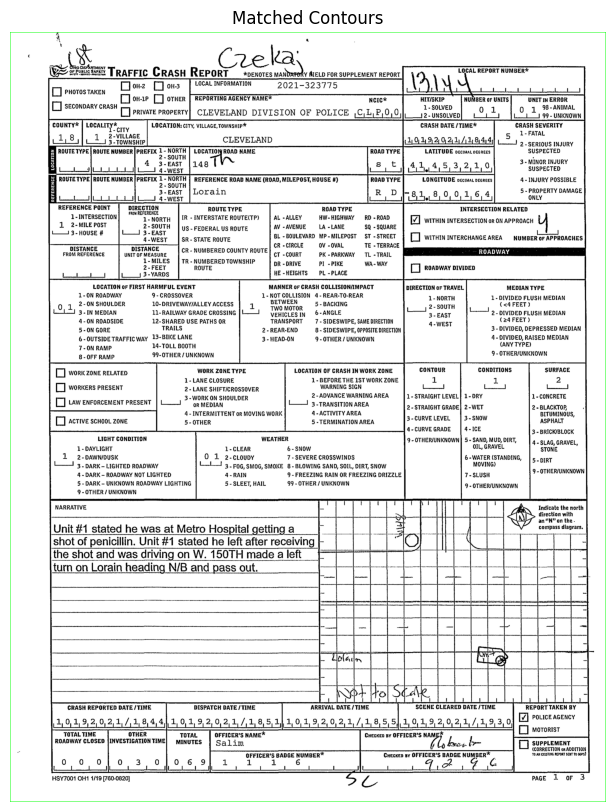

In [135]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def match_template_contours(template_contours, image_contours, threshold=0.2):
    """
    Match template contours to observed image contours based on shape similarity.
    Args:
        template_contours: List of contours from the template.
        image_contours: List of contours from the observed image.
        threshold: Similarity threshold. Lower values mean a closer match.
    Returns:
        matched_contours: List of matched contours from the image.
    """
    matched_contours = []

    for template_contour in template_contours:
        for image_contour in image_contours:
            # Use cv2.matchShapes to compare the template and image contours
            similarity = cv2.matchShapes(
                template_contour, image_contour, cv2.CONTOURS_MATCH_I1, 0.0
            )

            if similarity < threshold:
                matched_contours.append(image_contour)

    return matched_contours


# Load the template and observed images (grayscale)
template_image = cv2.imread(
    "../data/raw/oh1_pdf_files/202100323775/page_1_template.png",
    cv2.IMREAD_GRAYSCALE,
)
observed_image = cv2.imread(
    "../data/raw/oh1_pdf_files/202100323775/page_1.png", cv2.IMREAD_GRAYSCALE
)

# Preprocess: Threshold the images to binary for contour detection
_, template_thresh = cv2.threshold(template_image, 127, 255, cv2.THRESH_BINARY)
_, observed_thresh = cv2.threshold(observed_image, 127, 255, cv2.THRESH_BINARY)

# Find contours in the template and observed images
template_contours, _ = cv2.findContours(
    template_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
observed_contours, _ = cv2.findContours(
    observed_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Match template contours to the observed image contours
matched_contours = match_template_contours(
    template_contours, observed_contours, threshold=0.2
)

# Draw the matched contours on the observed image
output_image = cv2.cvtColor(observed_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    output_image, matched_contours, -1, (0, 255, 0), 2
)  # Green color for matched contours

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Matched Contours")
plt.axis("off")
plt.show()

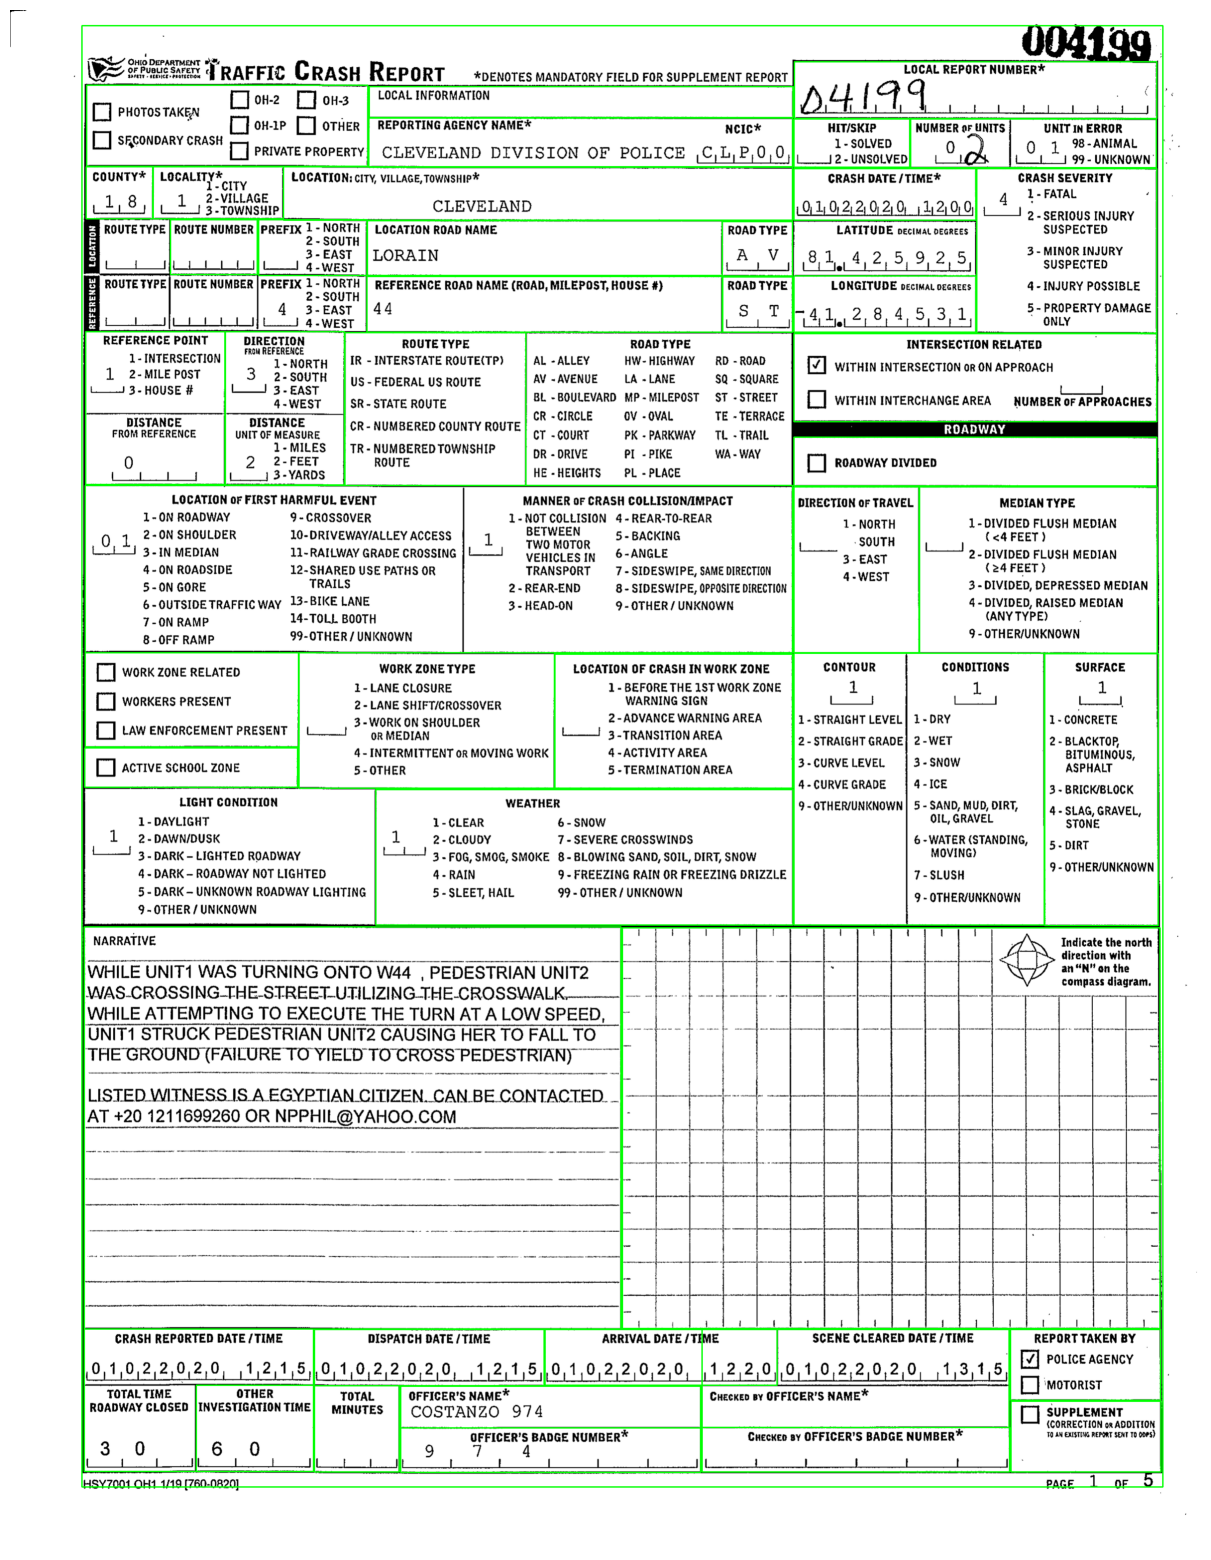

In [222]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cad_id = "202000001607"


def convert_pdf_to_images(pdf_path, output_folder, dpi=300):
    # Convert PDF pages to images
    images = convert_from_path(pdf_path, dpi=dpi)

    image_files = []
    for i, image in enumerate(images):
        # Save each page as a PNG file
        image_path = os.path.join(output_folder, f"page_{i + 1}.png")
        image.save(image_path, "PNG")
        image_files.append(image_path)
    return image_files


# Main function to process PDF files
def process_pdf_file(pdf_path, output_folder):
    # Convert PDF to images
    image_files = convert_pdf_to_images(pdf_path, output_folder)


# Example usage:
pdf_file_path = (
    "../data/raw/oh1_pdf_files/202000001607.pdf"  # Path to your PDF file
)
output_folder = (
    "../data/raw/oh1_pdf_files/202000001607"  # Folder to store images
)
os.makedirs(output_folder, exist_ok=True)

# Process the PDF file
process_pdf_file(pdf_file_path, output_folder)

template = cv2.imread("../data/raw/page_1_template.png", cv2.IMREAD_GRAYSCALE)
form = cv2.imread(
    f"../data/raw/oh1_pdf_files/202000001607/page_1.png", cv2.IMREAD_GRAYSCALE
)

# Resize form to match template size if necessary
form = cv2.resize(form, (template.shape[1], template.shape[0]))

# Step 1: Preprocess the image
# Apply Gaussian blur to remove noise and smooth the image
blurred_template = cv2.GaussianBlur(template, (5, 5), 0)
blurred_form = cv2.GaussianBlur(form, (5, 5), 0)

# Step 2: Use Canny edge detection to highlight the edges
edges_template = cv2.Canny(blurred_template, 20, 30)
edges_form = cv2.Canny(blurred_form, 100, 175)

# Step 3: Detect contours from the edges (this will detect boxes)
contours_template, _ = cv2.findContours(
    edges_template, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
contours_form, _ = cv2.findContours(
    edges_form, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)


# Step 4: Filter the contours to get bounding boxes
def get_bounding_boxes(contours, min_area=100, min_width=100, min_height=50):
    boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(contour)
            # Add filters for minimum width and height
            if w > min_width and h > min_height:
                boxes.append((x, y, x + w, y + h))
    return boxes


# Get bounding boxes from the template and form
template_boxes = get_bounding_boxes(contours_template)
form_boxes = get_bounding_boxes(contours_form)

# Step 5: Visualize the detected bounding boxes
# Draw bounding boxes on the template
template_copy = cv2.cvtColor(template, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in template_boxes:
    cv2.rectangle(template_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Draw bounding boxes on the form
form_copy = cv2.cvtColor(form, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in form_boxes:
    cv2.rectangle(form_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Step 6: Extract the regions from the observed form based on the template
output_boxes_folder = "../data/raw/oh1_pdf_files/202000001607/boxes"  # Folder to save the individual boxes
if not os.path.exists(output_boxes_folder):
    os.makedirs(output_boxes_folder)

# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(form_copy, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

output_folder = "../data/raw/oh1_pdf_files/202000001607"  # Folder to save the individual boxes
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

extracted_images = []
box_count = 0
officer_narrative = "UNKNOWN EVENTS"
severity_desc = "UNKNOWN INJURY CAUSED BY "

for x1, y1, x2, y2 in template_boxes:
    # Find corresponding region in the form
    for fx1, fy1, fx2, fy2 in form_boxes:
        # Assuming that box locations in the form match approximately in location and size
        if abs(x1 - fx1) < 20 and abs(y1 - fy1) < 20:
            extracted_region = form[fy1:fy2, fx1:fx2]
            extracted_images.append(extracted_region)
            box_count += 1
            box_image = form[fy1:fy2, fx1:fx2]
            box_image_path = os.path.join(
                output_boxes_folder, f"box_{box_count}.png"
            )
            cv2.imwrite(box_image_path, box_image)
            text = pytesseract.image_to_string(box_image)
            text = re.sub(r"\s+", " ", text).strip().upper()
            if "NARRATIVE" in text:
                officer_narrative = text[10:]
            if "SEVERITY" in text:
                severity = text[15:16]
                if severity == "1":
                    severity_desc = "FATAL INJURY CAUSED BY "
                if severity == "2":
                    severity_desc = "SERIOUS INJURY CAUSED BY "
                if severity == "3":
                    severity_desc = "MINOR INJURY CAUSED BY "
                if severity == "4":
                    severity_desc = "INJURY POSSIBLE CAUSED BY "
                if severity == "5":
                    severity_desc = "PROPERTY DAMAGE CAUSED BY "

oh1_narrative = severity_desc + officer_narrative
oh1_narrative_file = os.path.join(output_folder, f"oh1_narrative_{cad_id}.txt")

with open(oh1_narrative_file, "w") as f:
    f.write(oh1_narrative)